___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

<h1 style="text-align: center;">Deep Learning<br><br>Assignment-2 (CNN)<br><br>Image Classification with CNN<br><h1>

# Task and Dataset Info

Welcome to second assignment of Deep learning lesson. Follow the instructions and complete the assignment.

**Build an image classifier with Convolutional Neural Networks for the Fashion MNIST dataset. This data set includes 10 labels of different clothing types with 28 by 28 *grayscale* images. There is a training set of 60,000 images and 10,000 test images.**

    Label	Description
    0	    T-shirt/top
    1	    Trouser
    2	    Pullover
    3	    Dress
    4	    Coat
    5	    Sandal
    6	    Shirt
    7	    Sneaker
    8	    Bag
    9	    Ankle boot

In [1]:
try:
    import jupyter_black
    jupyter_black.load()
except ImportError:
    print("You can safely ignore this message.")

You can safely ignore this message.


# Import Libraries

In [2]:
import os

# Set TF log level to ignore INFOs.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten,Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, multilabel_confusion_matrix,)

plt.rcParams["figure.figsize"] = (10, 6)

sns.set_style("whitegrid")
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option("display.max_columns", None)

np.set_printoptions(suppress=True)

In [4]:
import tensorflow as tf

if tf.config.list_physical_devices("GPU"):
    print("GPU support is enabled for this session.")
else:
    print("CPU will be used for this session.")

CPU will be used for this session.


# Recognizing and Understanding Data

**TASK 1: Run the code below to download the dataset using Keras.**

In [5]:
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 2s 1us/step


In [6]:
#validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size = 0.10,
                                                  random_state = 42,
                                                  stratify = y_train)


In [7]:
print(f"There are {len(X_train)} images in the training dataset")
print(f"There are {len(X_test)} images in the test dataset")
print(f"There are {len(X_val)} images in the validation dataset")

There are 54000 images in the training dataset
There are 10000 images in the test dataset
There are 6000 images in the validation dataset


In [8]:
# Checking the shape of one image
X_train[359].shape

(28, 28)

**TASK 2: Use matplotlib to view an image from the data set. It can be any image from the data set.**

In [9]:
classes=["T-shirt/top", "Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

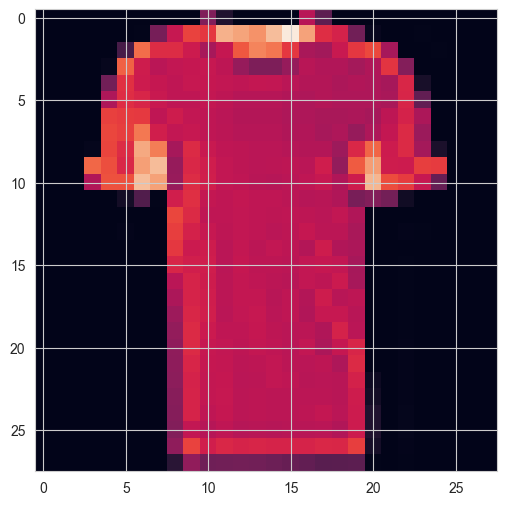

In [10]:
plt.imshow(X_train[359])

<Axes: >

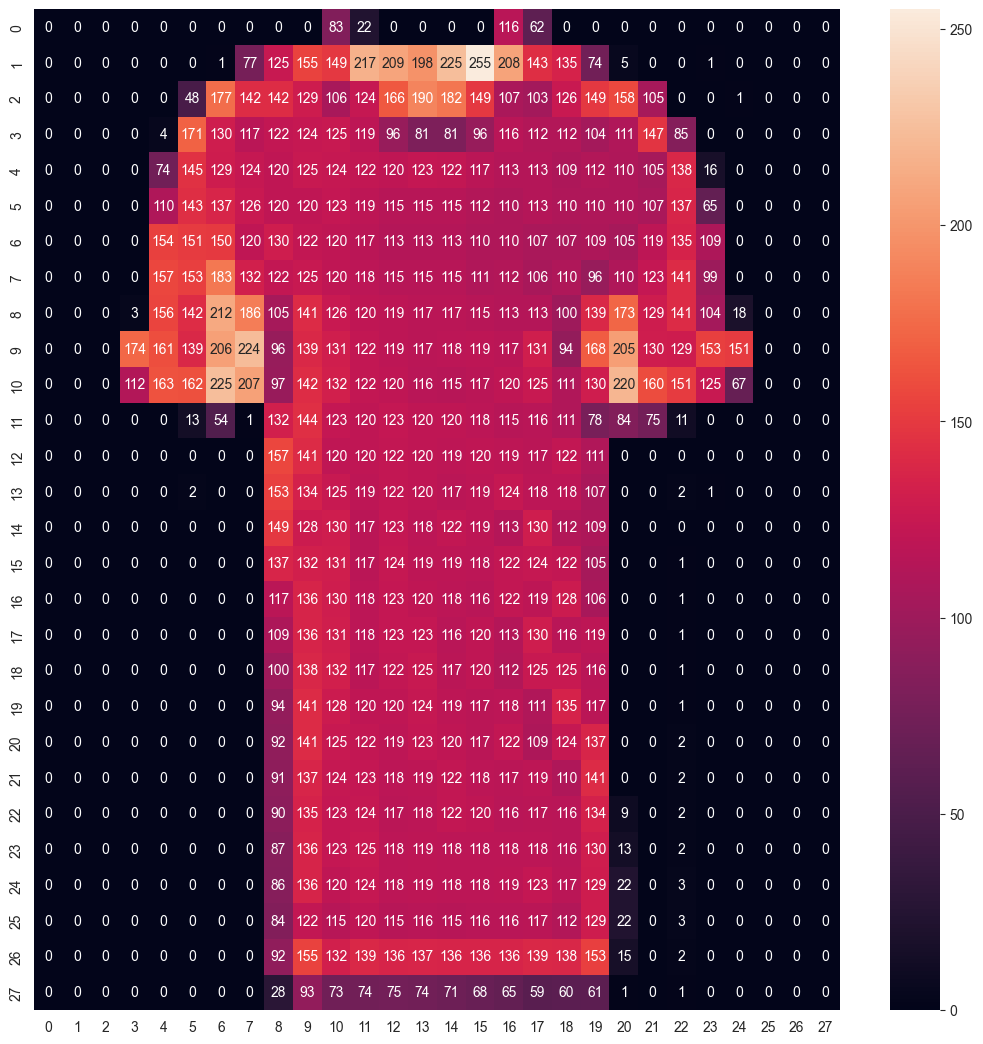

In [11]:
plt.figure(figsize=(13, 13))
sns.heatmap(X_train[359], annot=True, fmt=".3g")

In [12]:
y_train[359]

0

In [13]:
classes[0]

'T-shirt/top'

In [14]:
classes[y_train[359]]

'T-shirt/top'

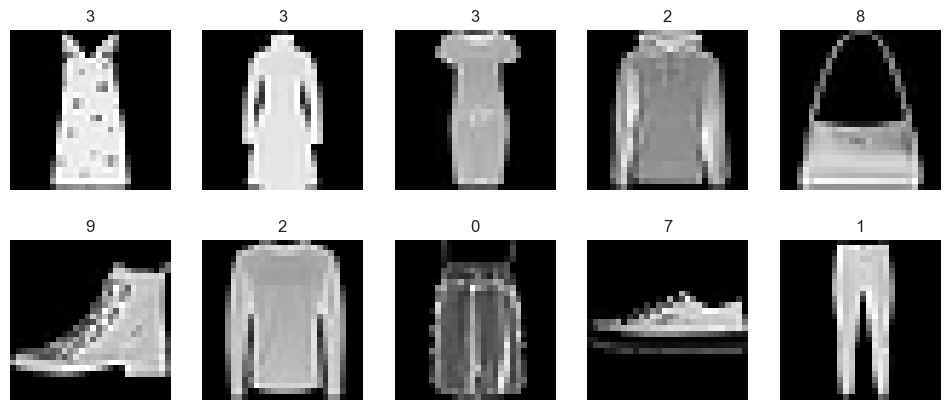

In [15]:
f, axes = plt.subplots(2, 5, figsize=(12, 5))

for ax in axes.ravel():
    idx = np.random.randint(0, len(X_train))
    ax.axis("off")
    ax.set_title(y_train[idx])
    ax.imshow(X_train[idx], cmap="gray")
plt.show()

# Data Preprocessing

**TASK 3: Normalize the X train and X test data by dividing by the max value of the image arrays.**

In [16]:
X_train[359].min()

0

In [17]:
X_train[359].max()

255

In [18]:
# Normalize image pixels
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_val = X_val.astype("float32")
X_train /= 255
X_test /= 255
X_val /= 255

In [19]:
X_train[9].min()

0.0

In [20]:
X_train[9].max()

1.0

In [21]:
X_val[9].min()

0.0

In [22]:
X_val[9].max()

1.0

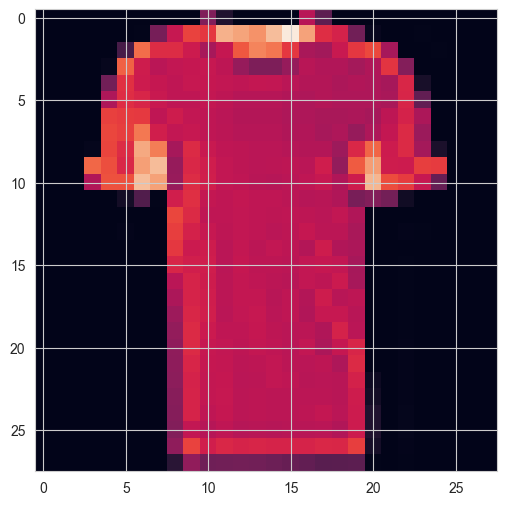

In [23]:
plt.imshow(X_train[359])
plt.show()

**Task 4: Reshape the X arrays to include a 4 dimension of the single channel. Similar to what we did for the numbers MNIST data set.**

In [24]:
X_train.shape, X_test.shape, X_val.shape

((54000, 28, 28), (10000, 28, 28), (6000, 28, 28))

In [25]:
X_train = np.expand_dims(X_train, 3)
X_test = np.expand_dims(X_test, 3)
X_val = np.expand_dims(X_val, 3)# fai wrote -1, it's the same as 3, it says: in which index do you add

In [26]:
X_train.shape, X_test.shape, X_val.shape

((54000, 28, 28, 1), (10000, 28, 28, 1), (6000, 28, 28, 1))

In [27]:
y_train

array([8, 9, 8, ..., 6, 1, 9], dtype=uint8)

In [28]:
y_train.shape

(54000,)

**TASK 5: Convert the y_train and y_test values to be one-hot encoded for categorical analysis by Keras.**

In [29]:
Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)
Y_val = to_categorical(y_val, 10)
Y_train.shape

(54000, 10)

In [30]:
y_train[359]

0

In [31]:
Y_train[359]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

# Modeling (model 1)

## Create the model

**TASK 5: Use Keras to create a model consisting of at least the following layers (but feel free to experiment):**

* 2D Convolutional Layer, filters=28 and kernel_size=(3,3)
* Pooling Layer where pool_size = (2,2) strides=(1,1)

* Flatten Layer
* Dense Layer (128 Neurons, but feel free to play around with this value), RELU activation

* Final Dense Layer of 10 Neurons with a softmax activation

**Then compile the model with these parameters: loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']**

In [32]:
model = Sequential()

model.add(Conv2D(filters=28, kernel_size=(3, 3),
                 input_shape=(28, 28, 1),
                 activation="relu"))  # stride = 1, padding = valid

model.add(MaxPool2D(pool_size=(2, 2), strides = (1,1)))  #padding = valid

model.add(Flatten())

model.add(Dense(128, activation="relu"))

model.add(Dense(10, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 28)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 17500)             0         
                                                                 
 dense (Dense)               (None, 128)               2240128   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 2241698 (8.55 MB)
Trainable params: 2241698 (8.55 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

##  Model Training

**TASK 6: Train/Fit the model to the x_train set by using EarlyStop. Amount of epochs is up to you.**

In [34]:
early_stop = EarlyStopping(
    monitor="val_accuracy", mode="max", patience=10, restore_best_weights=True
)

In [35]:
model.fit(
    X_train,
    Y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, Y_val),
    callbacks=[early_stop],
)

Epoch 1/50


1688/1688 [==============================] - 67s 39ms/step - loss: 0.4120 - accuracy: 0.8554 - val_loss: 0.2820 - val_accuracy: 0.8998
Epoch 2/50
1688/1688 [==============================] - 68s 40ms/step - loss: 0.2730 - accuracy: 0.9019 - val_loss: 0.2708 - val_accuracy: 0.8980
Epoch 3/50
1688/1688 [==============================] - 68s 40ms/step - loss: 0.2294 - accuracy: 0.9173 - val_loss: 0.2550 - val_accuracy: 0.9120
Epoch 4/50
1688/1688 [==============================] - 68s 40ms/step - loss: 0.1998 - accuracy: 0.9272 - val_loss: 0.2367 - val_accuracy: 0.9165
Epoch 5/50
1688/1688 [==============================] - 68s 40ms/step - loss: 0.1758 - accuracy: 0.9364 - val_loss: 0.2400 - val_accuracy: 0.9202
Epoch 6/50
1688/1688 [==============================] - 91s 54ms/step - loss: 0.1566 - accuracy: 0.9435 - val_loss: 0.2383 - val_accuracy: 0.9155
Epoch 7/50
1688/1688 [==============================] - 90s 54ms/step - loss: 0.1393 - accuracy: 0.9492 - val_loss: 0.2522 - val_accura

**TASK 7: Plot values of metrics you used in your model.**

In [36]:
summary = pd.DataFrame(model.history.history)
summary.head()

,loss,accuracy,val_loss,val_accuracy
0,0.412,0.855,0.282,0.900
1,0.273,0.902,0.271,0.898
2,0.229,0.917,0.255,0.912
3,0.200,0.927,0.237,0.916
4,0.176,0.936,0.240,0.920


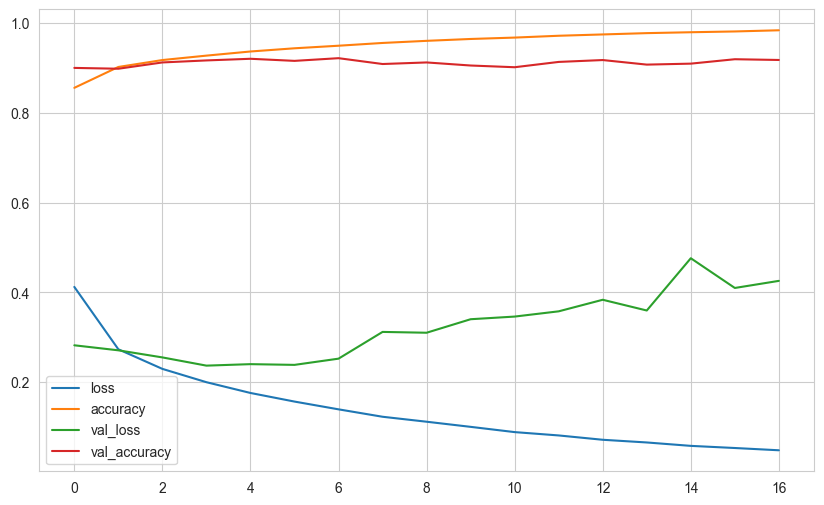

In [37]:
summary.plot();

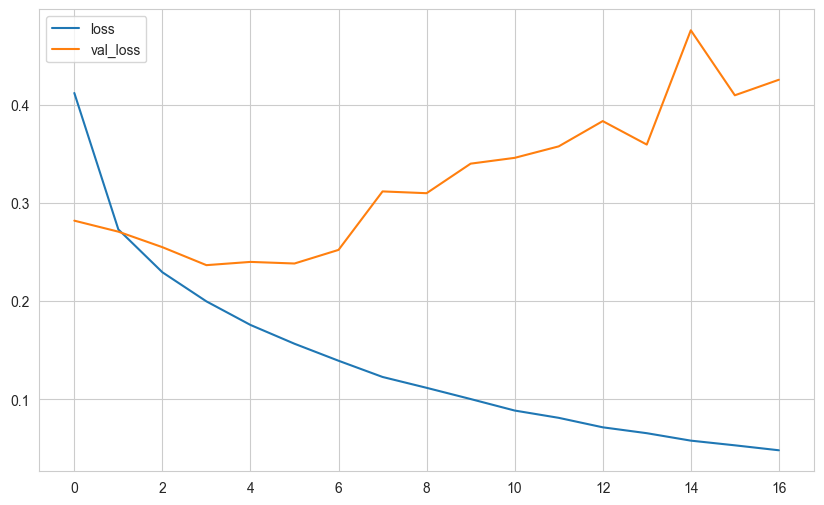

In [38]:
summary[["loss", "val_loss"]].plot();

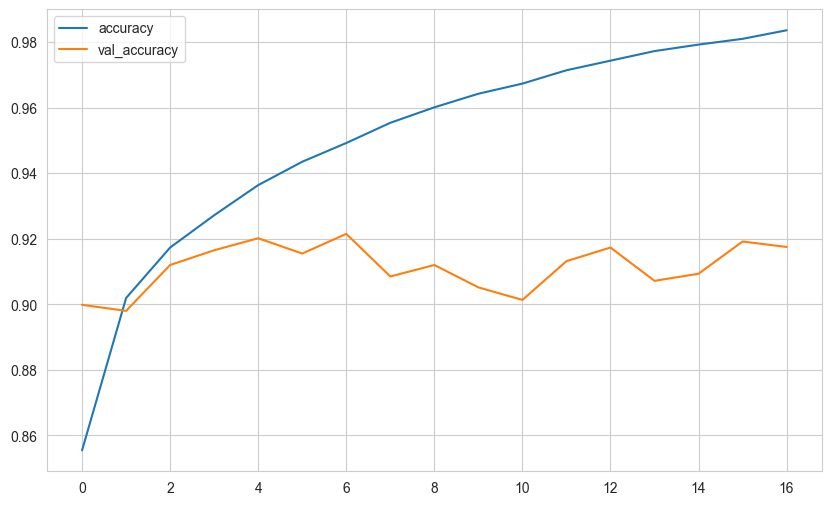

In [39]:
summary[["accuracy", "val_accuracy"]].plot();

## Model Evaluation

**TASK 8: Show the accuracy,precision,recall,f1-score the model achieved on the x_test data set. Keep in mind, there are quite a few ways to do this, but we recommend following the same procedure we showed in the MNIST lecture.**

In [40]:
score_vanilla = model.evaluate(X_test, Y_test, verbose=0)
print("Test loss:", score_vanilla[0])
print("Test accuracy:", score_vanilla[1])

Test loss: 0.3059961795806885
Test accuracy: 0.9064000248908997


In [41]:
pred_prob = model.predict(X_test)
pred_prob

313/313 [==============================] - 3s 8ms/step


array([[0.00000001, 0.        , 0.        , ..., 0.00016166, 0.        ,
        0.999816  ],
       [0.00000005, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00011081, 0.00000266, 0.00046079, ..., 0.00351749, 0.00004393,
        0.00011126]], dtype=float32)

In [42]:
pred_prob[0]

array([0.00000001, 0.        , 0.        , 0.        , 0.00000002,
       0.00002215, 0.00000014, 0.00016166, 0.        , 0.999816  ],
      dtype=float32)

In [43]:
np.argmax(pred_prob[0])

9

In [44]:
y_pred = np.argmax(pred_prob, axis=1)
y_pred

array([9, 2, 1, ..., 8, 1, 5], dtype=int64)

In [45]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[880   0  24  11   7   1  67   0  10   0]
 [  2 982   1   9   2   0   2   0   2   0]
 [ 15   0 882   9  50   1  41   0   2   0]
 [ 15   8  11 918  25   0  19   0   4   0]
 [  2   1  90  20 861   0  24   0   2   0]
 [  0   0   0   0   1 971   0  19   2   7]
 [131   0  88  26  87   0 653   0  15   0]
 [  0   0   0   0   0  11   0 974   0  15]
 [  2   1   2   2   2   3   1   2 985   0]
 [  1   0   0   0   0   8   0  33   0 958]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1000
           1       0.99      0.98      0.99      1000
           2       0.80      0.88      0.84      1000
           3       0.92      0.92      0.92      1000
           4       0.83      0.86      0.85      1000
           5       0.98      0.97      0.97      1000
           6       0.81      0.65      0.72      1000
           7       0.95      0.97      0.96      1000
           8       0.96      0.98      0.97      1000
           9       0.98     

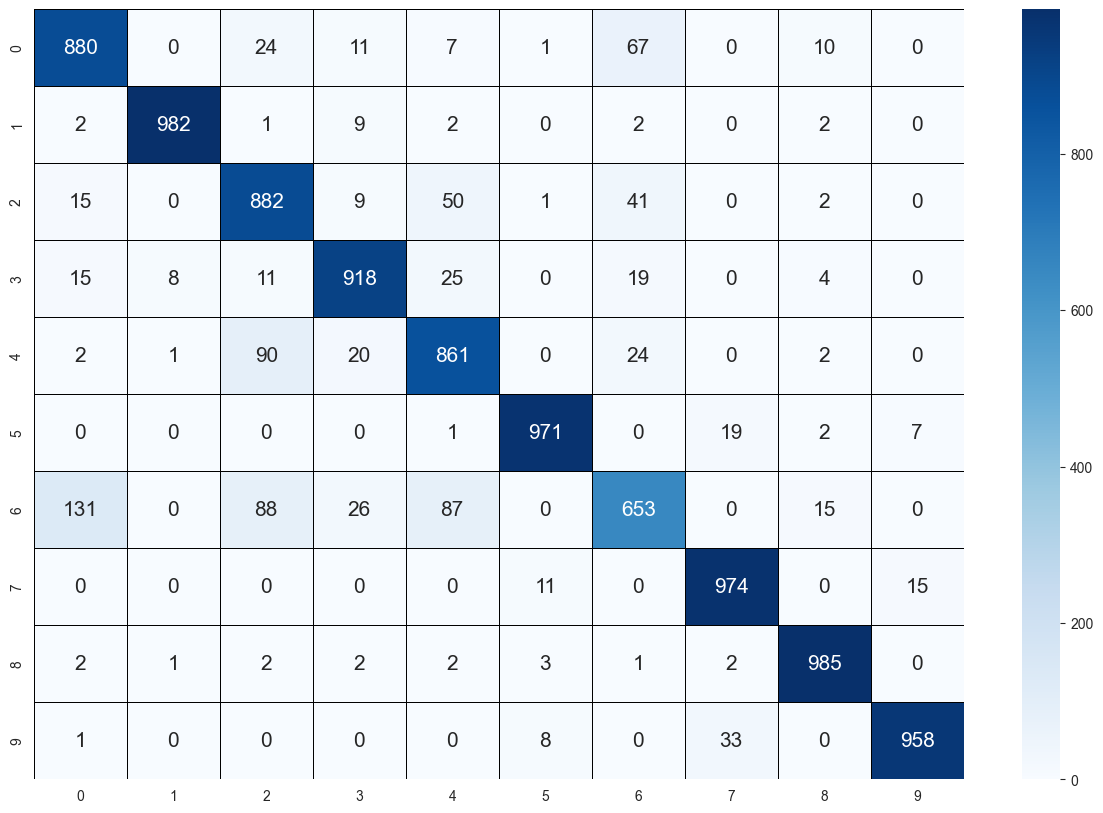

In [46]:
plt.figure(figsize=(15, 10))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    cmap="Blues",
    linewidths=0.5,
    linecolor="black",
    fmt="g",
    annot_kws={"size": 15},
)
plt.show()

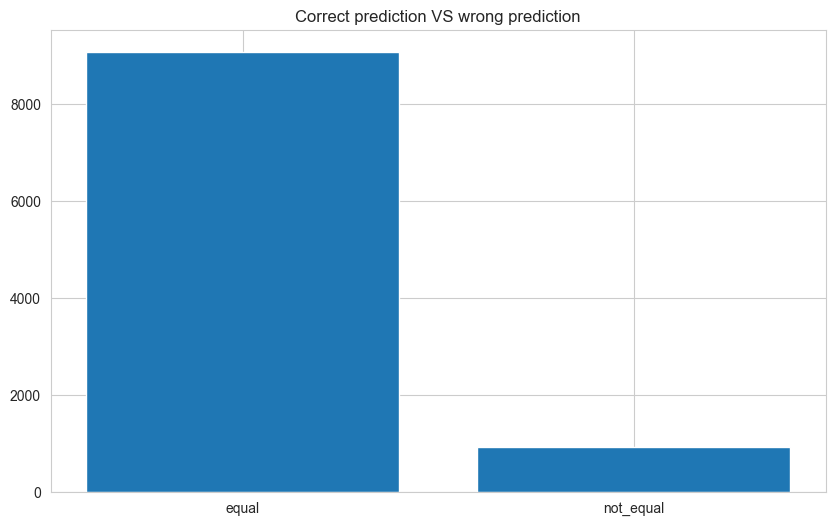

In [47]:
equal = np.equal(y_test, y_pred).sum()
not_equal= np.not_equal(y_test, y_pred).sum()
plt.bar(['equal','not_equal'] , [equal,not_equal] )
plt.title("Correct prediction VS wrong prediction")
plt.show();

## Prediction

In [48]:
my_number = X_test[3]

In [49]:
my_number.shape

(28, 28, 1)

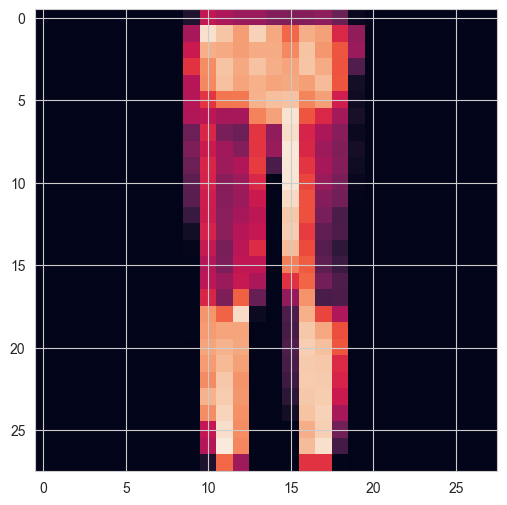

In [50]:
plt.imshow(my_number)
plt.show()

In [51]:
np.expand_dims(my_number, 0).shape

(1, 28, 28, 1)

In [52]:
pred_prob_final = model.predict(np.expand_dims(my_number, 0))
pred_prob_final

1/1 [==============================] - 0s 25ms/step


array([[0.        , 1.        , 0.        , 0.00000001, 0.00000001,
        0.        , 0.        , 0.        , 0.        , 0.        ]],
      dtype=float32)

In [53]:
# SHAPE --> (num_images, width, height, color_channels)
y_pred_final = np.argmax(pred_prob_final)
y_pred_final

1

In [54]:
classes[y_pred_final]

'Trouser'

In [55]:
model.save("assign1-DL_model.h5")

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Using the saved model

In [56]:
model = tf.keras.models.load_model("assign1-DL_model.h5")

In [57]:
pred_final = model.predict(np.expand_dims(X_test[24], 0))

1/1 [==============================] - 0s 64ms/step


In [58]:
np.argmax(pred_final)

1

In [59]:
classes[np.argmax(pred_final)]

'Trouser'

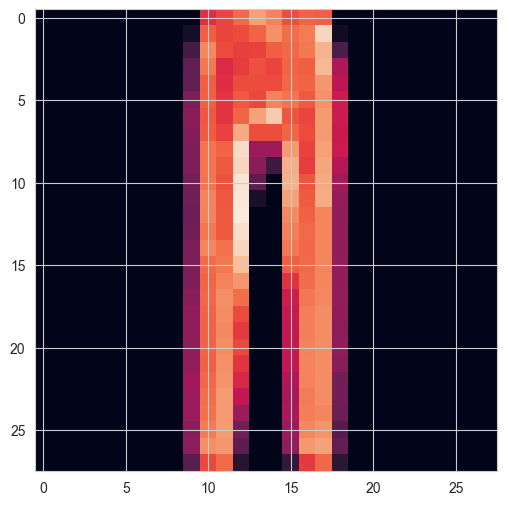

In [60]:
plt.imshow(X_test[24].reshape(28, 28))
plt.show()

# another models with modifications (try new hyperparameters)

## regularized model

In [61]:
from keras import regularizers

In [62]:
model_l2_reg = Sequential()

model_l2_reg.add(Conv2D(filters=16, kernel_size=(3, 3),
                 input_shape=(28, 28, 1),
                 activation="relu"))  # stride = 1, padding = valid
model_l2_reg.add(MaxPool2D(pool_size=(2, 2), strides = (1,1)))  #padding = valid

model_l2_reg.add(Conv2D(filters=32, kernel_size=(3, 3),
                 input_shape=(28, 28, 1),
                 activation="relu"))  # stride = 1, padding = valid
model_l2_reg.add(MaxPool2D(pool_size=(2, 2), strides = (1,1)))  #padding = valid

model_l2_reg.add(Flatten())

model_l2_reg.add(Dense(128,kernel_regularizer=regularizers.l2(0.01), activation="relu"))

model_l2_reg.add(Dense(10, activation="softmax"))

model_l2_reg.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [63]:
model_l2_reg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 25, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 22, 22, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 15488)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

### train

In [64]:
model_l2_reg.fit(
    X_train,
    Y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, Y_val),
    callbacks=[early_stop],
)

Epoch 1/50


1688/1688 [==============================] - 116s 68ms/step - loss: 0.7158 - accuracy: 0.8018 - val_loss: 0.5600 - val_accuracy: 0.8393
Epoch 2/50
1688/1688 [==============================] - 118s 70ms/step - loss: 0.5576 - accuracy: 0.8428 - val_loss: 0.5384 - val_accuracy: 0.8505
Epoch 3/50
1688/1688 [==============================] - 120s 71ms/step - loss: 0.5190 - accuracy: 0.8564 - val_loss: 0.4939 - val_accuracy: 0.8690
Epoch 4/50
1688/1688 [==============================] - 118s 70ms/step - loss: 0.4895 - accuracy: 0.8651 - val_loss: 0.4500 - val_accuracy: 0.8765
Epoch 5/50
1688/1688 [==============================] - 118s 70ms/step - loss: 0.4684 - accuracy: 0.8700 - val_loss: 0.4756 - val_accuracy: 0.8648
Epoch 6/50
1688/1688 [==============================] - 119s 71ms/step - loss: 0.4530 - accuracy: 0.8739 - val_loss: 0.4698 - val_accuracy: 0.8652
Epoch 7/50
1688/1688 [==============================] - 119s 70ms/step - loss: 0.4404 - accuracy: 0.8782 - val_loss: 0.4297 - val

In [65]:
summary_l2_reg = pd.DataFrame(model_l2_reg.history.history)
summary_l2_reg.head()

,loss,accuracy,val_loss,val_accuracy
0,0.716,0.802,0.560,0.839
1,0.558,0.843,0.538,0.850
2,0.519,0.856,0.494,0.869
3,0.489,0.865,0.450,0.877
4,0.468,0.870,0.476,0.865


### evaluate

In [66]:
score_l2_reg = model_l2_reg.evaluate(X_test, Y_test, verbose=0)
print("Test loss:", score_l2_reg[0])
print("Test accuracy:", score_l2_reg[1])

Test loss: 0.4111103117465973
Test accuracy: 0.8847000002861023


In [67]:
pred_prob_l2_reg = model_l2_reg.predict(X_test)
pred_prob_l2_reg

313/313 [==============================] - 3s 11ms/step


array([[0.        , 0.00000002, 0.        , ..., 0.00663068, 0.00000055,
        0.9932312 ],
       [0.0000517 , 0.        , 0.9978175 , ..., 0.00000004, 0.0000009 ,
        0.00000018],
       [0.00000067, 0.99999356, 0.0000003 , ..., 0.00000001, 0.00000025,
        0.00000001],
       ...,
       [0.00000707, 0.        , 0.00000027, ..., 0.00000007, 0.9999273 ,
        0.00000005],
       [0.0000014 , 0.9999801 , 0.00000105, ..., 0.00000009, 0.00000075,
        0.00000017],
       [0.00109849, 0.00005167, 0.0001725 , ..., 0.33717385, 0.05234729,
        0.00867065]], dtype=float32)

In [68]:
y_pred_l2_reg = np.argmax(pred_prob_l2_reg, axis=1)
y_pred_l2_reg

array([9, 2, 1, ..., 8, 1, 5], dtype=int64)

In [69]:
print(confusion_matrix(y_test, y_pred_l2_reg))
print(classification_report(y_test, y_pred_l2_reg))

[[814   0  13  29   0   2 123   0  18   1]
 [  0 965   0  24   4   0   4   0   3   0]
 [ 10   1 848   7  50   0  82   0   2   0]
 [ 13   3  16 904  26   0  35   0   2   1]
 [  0   1  72  32 764   0 127   0   3   1]
 [  0   0   0   0   0 933   0  18   0  49]
 [100   0  77  35  54   0 716   0  18   0]
 [  0   0   0   0   0   9   0 950   1  40]
 [  1   1   3   2   2   4   5   1 981   0]
 [  0   0   0   0   0   1   2  25   0 972]]
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1000
           1       0.99      0.96      0.98      1000
           2       0.82      0.85      0.84      1000
           3       0.88      0.90      0.89      1000
           4       0.85      0.76      0.80      1000
           5       0.98      0.93      0.96      1000
           6       0.65      0.72      0.68      1000
           7       0.96      0.95      0.95      1000
           8       0.95      0.98      0.97      1000
           9       0.91     

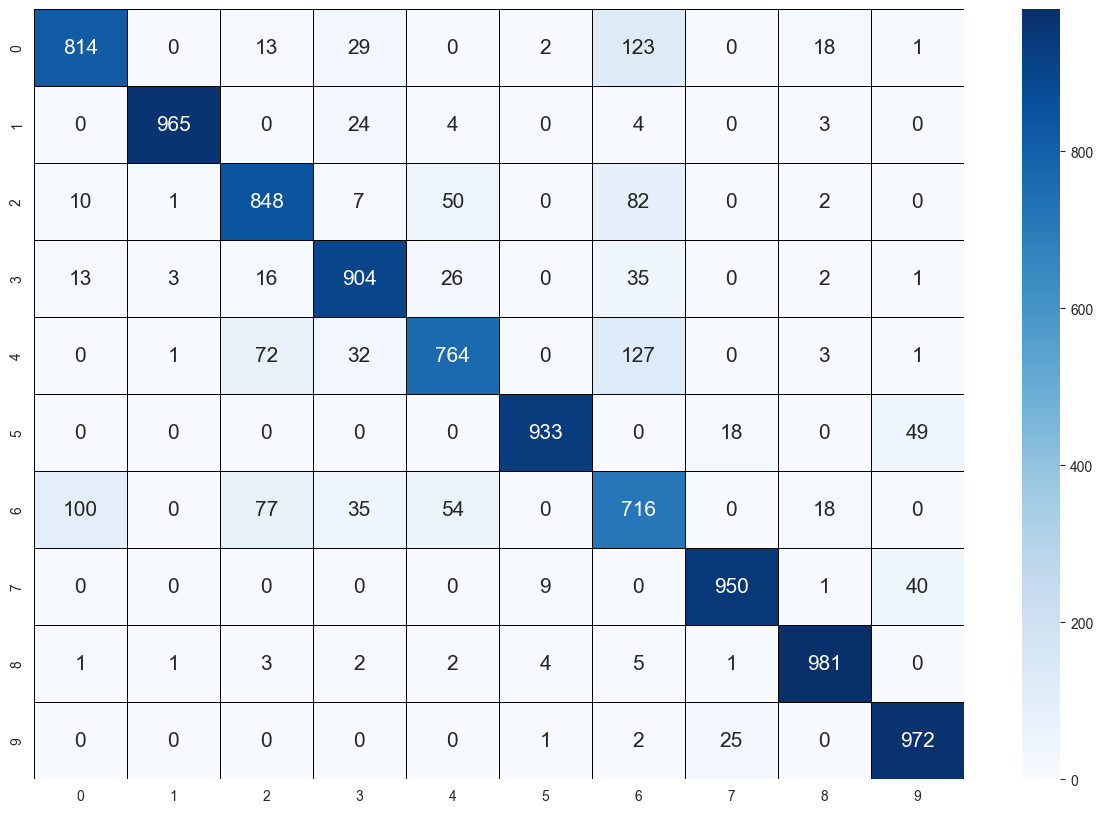

In [70]:
plt.figure(figsize=(15, 10))
sns.heatmap(
    confusion_matrix(y_test, y_pred_l2_reg),
    annot=True,
    cmap="Blues",
    linewidths=0.5,
    linecolor="black",
    fmt="g",
    annot_kws={"size": 15},
)
plt.show()

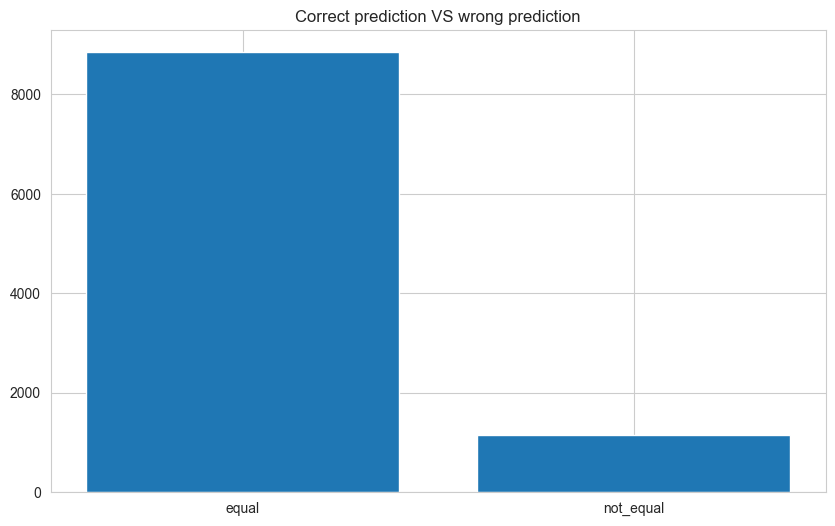

In [71]:
equal_l2_reg = np.equal(y_test, y_pred_l2_reg).sum()
not_equal_l2_reg= np.not_equal(y_test, y_pred_l2_reg).sum()
plt.bar(['equal','not_equal'] , [equal_l2_reg,not_equal_l2_reg] )
plt.title("Correct prediction VS wrong prediction")
plt.show();

## dropout model

In [72]:
model_dropout = Sequential()

model_dropout.add(Conv2D(filters=16, kernel_size=(3, 3),
                 input_shape=(28, 28, 1),
                 activation="relu"))  # stride = 1, padding = valid
model_dropout.add(MaxPool2D(pool_size=(2, 2), strides = (1,1)))  #padding = valid

model_dropout.add(Conv2D(filters=32, kernel_size=(3, 3),
                 input_shape=(28, 28, 1),
                 activation="relu"))  # stride = 1, padding = valid
model_dropout.add(MaxPool2D(pool_size=(2, 2), strides = (1,1)))  #padding = valid
model_dropout.add(Dropout(0.2))

model_dropout.add(Flatten())

model_dropout.add(Dense(128, activation="relu"))
model_dropout.add(Dropout(0.2))

model_dropout.add(Dense(10, activation="softmax"))

model_dropout.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [73]:
model_dropout.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 25, 25, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 23, 23, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 22, 22, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 22, 22, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 15488)            

### train

In [74]:
model_dropout.fit(
    X_train,
    Y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, Y_val),
    callbacks=[early_stop],
)

Epoch 1/50
1688/1688 [==============================] - 120s 71ms/step - loss: 0.4524 - accuracy: 0.8395 - val_loss: 0.2988 - val_accuracy: 0.8890
Epoch 2/50
1688/1688 [==============================] - 121s 72ms/step - loss: 0.2956 - accuracy: 0.8944 - val_loss: 0.2570 - val_accuracy: 0.9072
Epoch 3/50
1688/1688 [==============================] - 123s 73ms/step - loss: 0.2554 - accuracy: 0.9089 - val_loss: 0.2364 - val_accuracy: 0.9172
Epoch 4/50
1688/1688 [==============================] - 123s 73ms/step - loss: 0.2313 - accuracy: 0.9185 - val_loss: 0.2354 - val_accuracy: 0.9118
Epoch 5/50
1688/1688 [==============================] - 125s 74ms/step - loss: 0.2151 - accuracy: 0.9226 - val_loss: 0.2444 - val_accuracy: 0.9182
Epoch 6/50
1688/1688 [==============================] - 125s 74ms/step - loss: 0.2002 - accuracy: 0.9285 - val_loss: 0.2164 - val_accuracy: 0.9270
Epoch 7/50
1688/1688 [==============================] - 125s 74ms/step - loss: 0.1910 - accuracy: 0.9319 - val_loss: 0

In [75]:
summary_dropout = pd.DataFrame(model_dropout.history.history)
summary_dropout.head()

,loss,accuracy,val_loss,val_accuracy
0,0.452,0.839,0.299,0.889
1,0.296,0.894,0.257,0.907
2,0.255,0.909,0.236,0.917
3,0.231,0.919,0.235,0.912
4,0.215,0.923,0.244,0.918


### evaluate

In [76]:
score_dropout = model_dropout.evaluate(X_test, Y_test, verbose=0)
print("Test loss:", score_dropout[0])
print("Test accuracy:", score_dropout[1])

Test loss: 0.3047312796115875
Test accuracy: 0.9157999753952026


In [77]:
pred_prob_dropout = model_dropout.predict(X_test)
pred_prob_dropout

313/313 [==============================] - 3s 8ms/step


array([[0.        , 0.        , 0.        , ..., 0.00000002, 0.        ,
        1.        ],
       [0.        , 0.        , 0.9999999 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0000002 , 0.00000011, 0.00000003, ..., 0.0088023 , 0.00000534,
        0.0000007 ]], dtype=float32)

In [78]:
y_pred_dropout = np.argmax(pred_prob_dropout, axis=1)
y_pred_dropout

array([9, 2, 1, ..., 8, 1, 5], dtype=int64)

In [79]:
print(confusion_matrix(y_test, y_pred_dropout))
print(classification_report(y_test, y_pred_dropout))

[[892   0  16  23   3   0  62   0   4   0]
 [  1 980   1  12   1   0   3   0   2   0]
 [ 23   1 914  12  26   0  23   0   1   0]
 [  4   2   5 964  12   0  12   0   1   0]
 [  0   0  99  43 815   0  40   0   3   0]
 [  0   0   0   0   0 976   0  21   0   3]
 [123   0  85  41  51   0 693   0   7   0]
 [  0   0   0   0   0   4   0 984   0  12]
 [  5   0   0   6   2   3   4   2 978   0]
 [  0   0   0   0   0   6   0  32   0 962]]
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1000
           1       1.00      0.98      0.99      1000
           2       0.82      0.91      0.86      1000
           3       0.88      0.96      0.92      1000
           4       0.90      0.81      0.85      1000
           5       0.99      0.98      0.98      1000
           6       0.83      0.69      0.75      1000
           7       0.95      0.98      0.97      1000
           8       0.98      0.98      0.98      1000
           9       0.98     

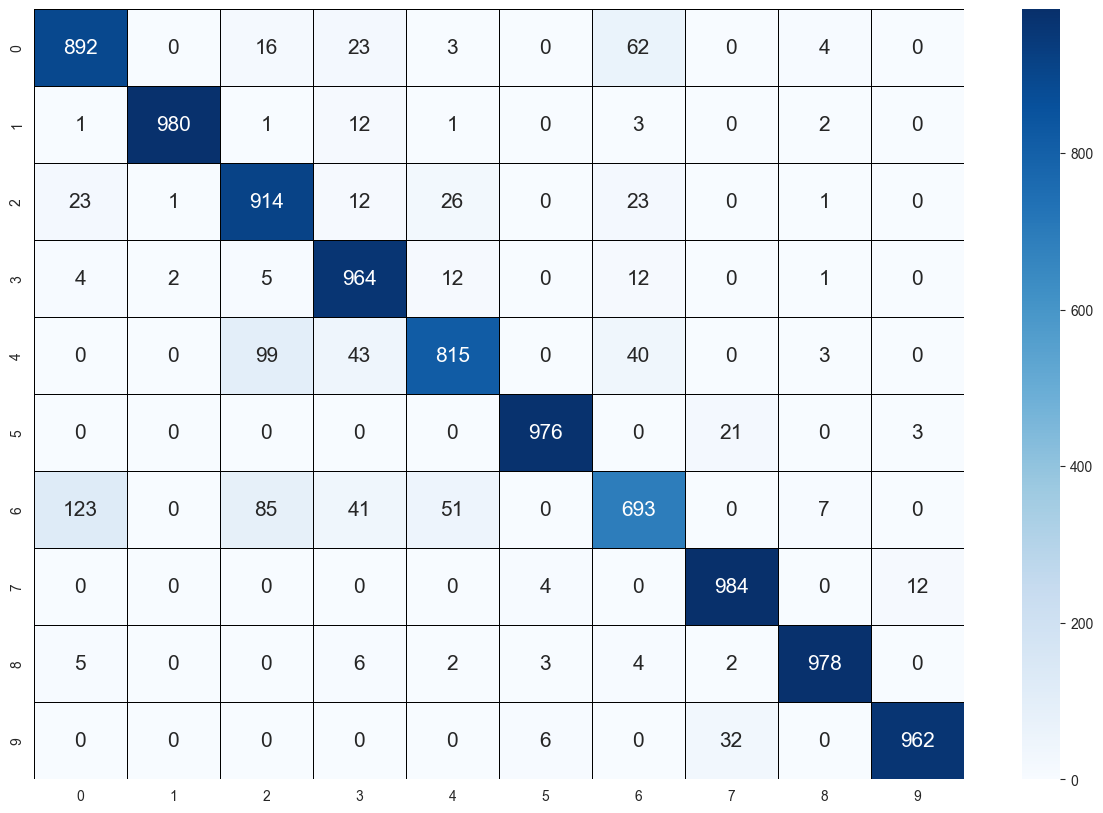

In [80]:
plt.figure(figsize=(15, 10))
sns.heatmap(
    confusion_matrix(y_test, y_pred_dropout),
    annot=True,
    cmap="Blues",
    linewidths=0.5,
    linecolor="black",
    fmt="g",
    annot_kws={"size": 15},
)
plt.show()

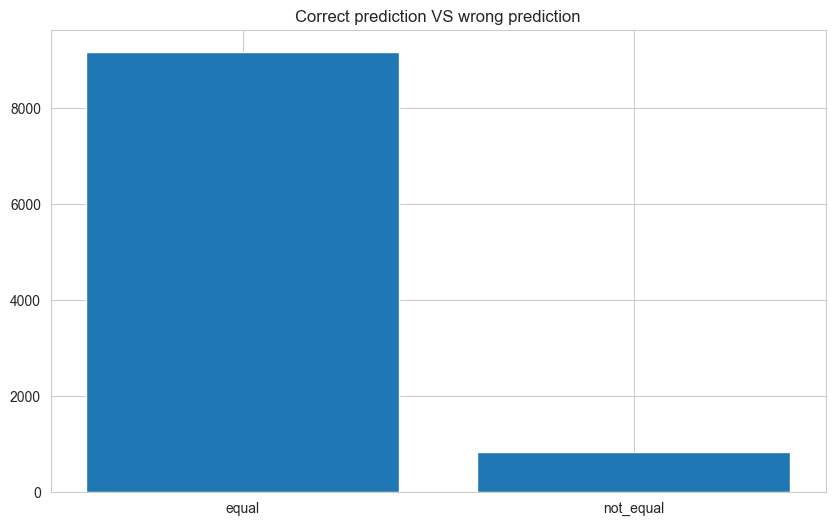

In [81]:
equal_dropout = np.equal(y_test, y_pred_dropout).sum()
not_equal_dropout= np.not_equal(y_test, y_pred_dropout).sum()
plt.bar(['equal','not_equal'] , [equal_dropout,not_equal_dropout] )
plt.title("Correct prediction VS wrong prediction")
plt.show();

## more complex model

In [85]:
model_x = Sequential()

model_x.add(Conv2D(filters=16, kernel_size=(3, 3),
                 input_shape=(28, 28, 1),
                 activation="relu"))
model_x.add(MaxPool2D(pool_size=(2, 2), strides = (1,1)))
model_x.add(Dropout(0.2))

model_x.add(Conv2D(filters=32, kernel_size=(3, 3),
                 input_shape=(28, 28, 1),
                 activation="relu"))
model_x.add(MaxPool2D(pool_size=(2, 2), strides = (1,1)))
model_x.add(Dropout(0.2))

model_x.add(Flatten())

model_x.add(Dense(128, kernel_regularizer=regularizers.l2(0.01), activation="relu"))
model_x.add(Dropout(0.2))

model_x.add(Dense(10, activation="softmax"))

model_x.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [86]:
model_x.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 25, 25, 16)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 25, 25, 16)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 23, 23, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 22, 22, 32)        0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 22, 22, 32)       

### train

In [87]:
model_x.fit(
    X_train,
    Y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, Y_val),
    callbacks=[early_stop],
)

Epoch 1/50
1688/1688 [==============================] - 133s 78ms/step - loss: 0.7851 - accuracy: 0.7904 - val_loss: 0.5839 - val_accuracy: 0.8468
Epoch 2/50
1688/1688 [==============================] - 135s 80ms/step - loss: 0.6206 - accuracy: 0.8326 - val_loss: 0.5616 - val_accuracy: 0.8600
Epoch 3/50
1688/1688 [==============================] - 136s 81ms/step - loss: 0.5864 - accuracy: 0.8432 - val_loss: 0.5233 - val_accuracy: 0.8738
Epoch 4/50
1688/1688 [==============================] - 137s 81ms/step - loss: 0.5637 - accuracy: 0.8504 - val_loss: 0.4793 - val_accuracy: 0.8845
Epoch 5/50
1688/1688 [==============================] - 137s 81ms/step - loss: 0.5458 - accuracy: 0.8554 - val_loss: 0.5038 - val_accuracy: 0.8667
Epoch 6/50
1688/1688 [==============================] - 139s 82ms/step - loss: 0.5390 - accuracy: 0.8580 - val_loss: 0.4696 - val_accuracy: 0.8808
Epoch 7/50
1688/1688 [==============================] - 139s 82ms/step - loss: 0.5360 - accuracy: 0.8595 - val_loss: 0

In [88]:
summary_x = pd.DataFrame(model_x.history.history)
summary_x.head()

,loss,accuracy,val_loss,val_accuracy
0,0.785,0.790,0.584,0.847
1,0.621,0.833,0.562,0.860
2,0.586,0.843,0.523,0.874
3,0.564,0.850,0.479,0.885
4,0.546,0.855,0.504,0.867


### evaluate

In [89]:
score_x = model_x.evaluate(X_test, Y_test, verbose=0)
print("Test loss:", score_x[0])
print("Test accuracy:", score_x[1])

Test loss: 0.4720463454723358
Test accuracy: 0.8877999782562256


In [90]:
pred_prob_x = model_x.predict(X_test)
pred_prob_x

313/313 [==============================] - 3s 9ms/step


array([[0.00000009, 0.00000024, 0.00000019, ..., 0.0004138 , 0.00000062,
        0.9994698 ],
       [0.00048174, 0.00000201, 0.9923482 , ..., 0.00000002, 0.00001941,
        0.00000002],
       [0.00031696, 0.9985875 , 0.00009796, ..., 0.00000604, 0.00004506,
        0.00001682],
       ...,
       [0.00000045, 0.        , 0.00000001, ..., 0.        , 0.99999785,
        0.00000001],
       [0.00012059, 0.99935395, 0.00002251, ..., 0.00000995, 0.00003511,
        0.00002971],
       [0.00112064, 0.00004495, 0.00008632, ..., 0.05152697, 0.0252089 ,
        0.00247363]], dtype=float32)

In [91]:
y_pred_x = np.argmax(pred_prob_x, axis=1)
y_pred_x

array([9, 2, 1, ..., 8, 1, 5], dtype=int64)

In [92]:
print(confusion_matrix(y_test, y_pred_x))
print(classification_report(y_test, y_pred_x))

[[800   1  14  20   1   1 153   0  10   0]
 [  1 961   2  13   3   0  19   0   1   0]
 [ 13   1 826   4  85   0  68   0   3   0]
 [  7   7  18 870  46   0  51   0   1   0]
 [  1   0  49  17 882   0  51   0   0   0]
 [  0   0   0   1   0 978   1  11   0   9]
 [ 91   2  64  28  93   0 708   0  14   0]
 [  0   0   0   0   0  19   0 940   0  41]
 [  1   0   9   6   4   3  22   2 952   1]
 [  0   0   0   0   0   6   4  29   0 961]]
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1000
           1       0.99      0.96      0.97      1000
           2       0.84      0.83      0.83      1000
           3       0.91      0.87      0.89      1000
           4       0.79      0.88      0.83      1000
           5       0.97      0.98      0.97      1000
           6       0.66      0.71      0.68      1000
           7       0.96      0.94      0.95      1000
           8       0.97      0.95      0.96      1000
           9       0.95     

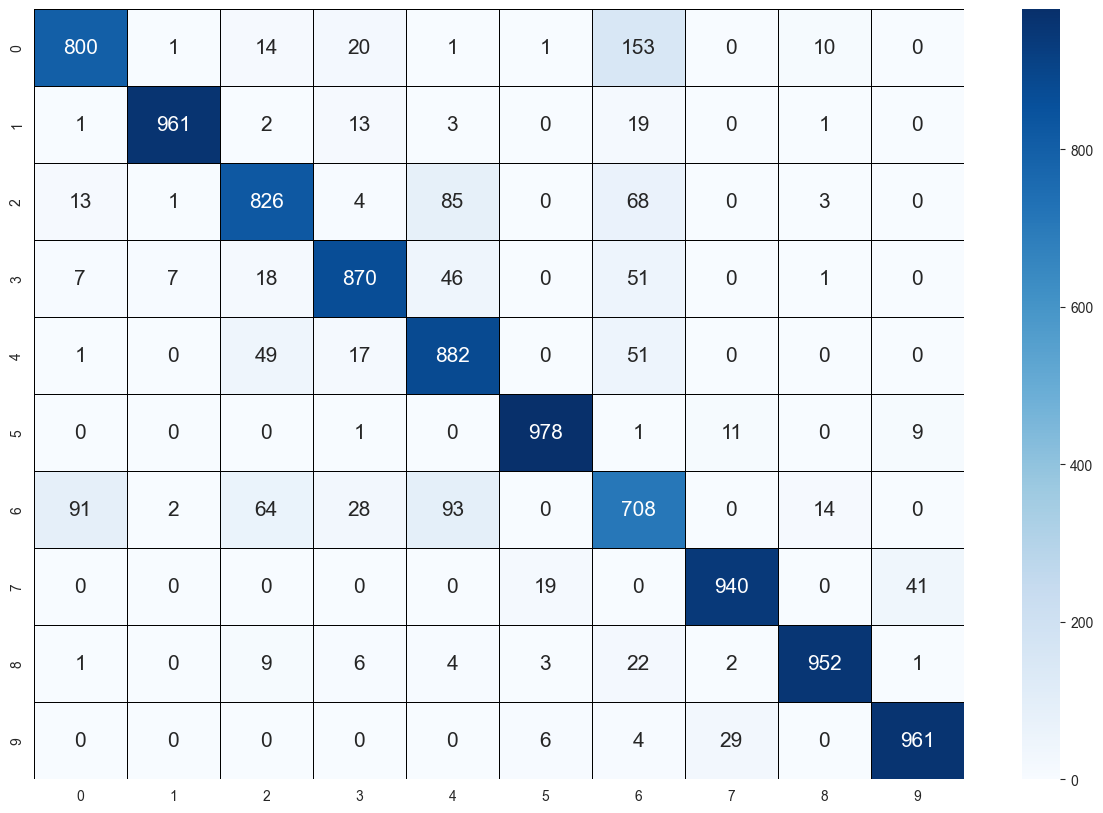

In [93]:
plt.figure(figsize=(15, 10))
sns.heatmap(
    confusion_matrix(y_test, y_pred_x),
    annot=True,
    cmap="Blues",
    linewidths=0.5,
    linecolor="black",
    fmt="g",
    annot_kws={"size": 15},
)
plt.show()

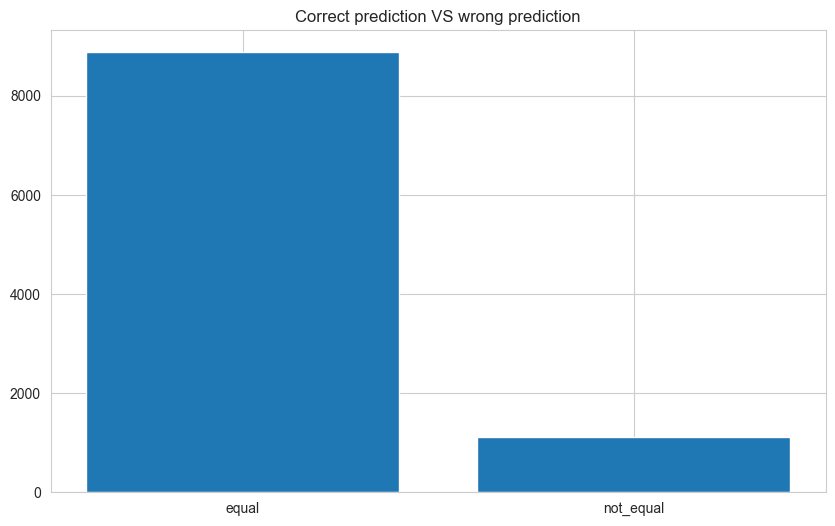

In [94]:
equal_x = np.equal(y_test, y_pred_x).sum()
not_equal_x= np.not_equal(y_test, y_pred_x).sum()
plt.bar(['equal','not_equal'] , [equal_x, not_equal_x] )
plt.title("Correct prediction VS wrong prediction")
plt.show();

# compare between the models

C:\Users\HP\AppData\Local\Temp\ipykernel_2728\2832942147.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Accuracy", y="Model", data=compare, palette="Blues_d")


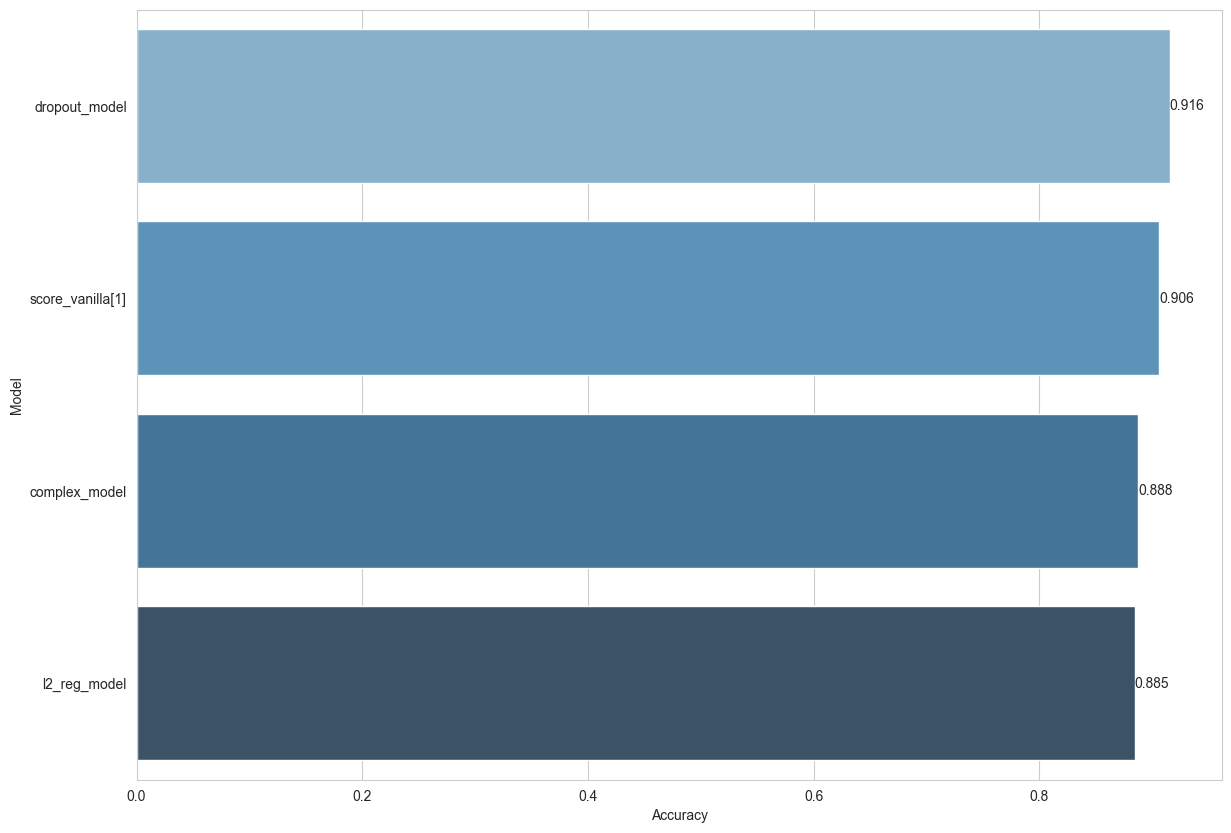

In [96]:
compare = pd.DataFrame(
    {
        "Model": ["score_vanilla[1]", "l2_reg_model","dropout_model", "complex_model"],
        "Accuracy": [score_vanilla[1], score_l2_reg[1], score_dropout[1], score_x[1]],
    }
)

plt.figure(figsize=(14, 10))
compare = compare.sort_values(by="Accuracy", ascending=False)
ax = sns.barplot(x="Accuracy", y="Model", data=compare, palette="Blues_d")
for label in ax.containers:
    ax.bar_label(label, fmt="%.3f")

# End of Assignment

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___